In [90]:
!nvidia-smi

Sun Dec 29 18:45:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8               1W / 140W |    327MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [91]:
def mul(*v):
    ret=1
    for x in v:
        ret*=x
    return ret

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm

from torchsummary import summary
from matplotlib import pyplot as plt
import numpy as np
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("cpu") #gpu driver error, switch to cpu for now
device

device(type='cuda')

In [93]:
l = torchvision.datasets.MNIST(root='./mnist_data/', train = True, download = True, transform = transforms.ToTensor())
t = torchvision.datasets.MNIST(root='./mnist_data/', train = False, download = True, transform = transforms.ToTensor())

In [94]:
l.data.shape,l.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [95]:
l.data[0].shape,l.targets[0]

(torch.Size([28, 28]), tensor(5))

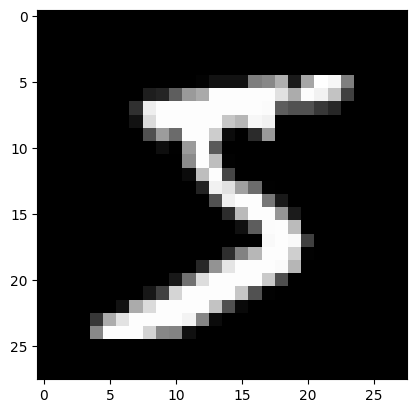

In [96]:
plt.imshow(l.data[0].numpy(), cmap='gray') 

In [97]:
x_l=l.data.numpy()
y_l=l.targets.numpy()
x_t=t.data.numpy()
y_t=t.targets.numpy()

In [98]:
'''
take first NUM_SIZE of imgs for each num
'''
L_NUM_SIZE=1000
count=np.zeros(10)
idx=[]
for i,num in enumerate(y_l):
    for j in range(10): #0~9 all imgs
        if num==j:
            count[j]+=1 #count each num in the training set
            if count[j]<=L_NUM_SIZE:
                idx.append(i)

idx=np.array(idx)


In [99]:
IMG_SIZE=(28,28)
IMG_DTYPE=np.float32
#COLOR_THRESHOLD=128

img_dim=mul(*IMG_SIZE)

#training set
yl=y_l[idx] #get selected imgs
xl=x_l[idx].astype(IMG_DTYPE)/255

#testing set
T_SIZE=1000
yt=y_t[:T_SIZE]
xt=x_t[:T_SIZE].astype(IMG_DTYPE)/255

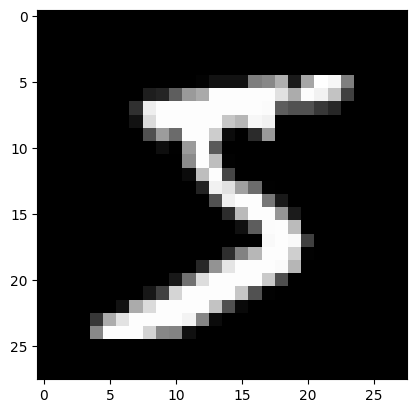

In [100]:
plt.imshow(xl[0], cmap='gray') 

In [101]:
L_BATCH_SIZE=64
T_BATCH_SIZE=100


#create dataloaders
ld=torch.utils.data.DataLoader(
    list(zip(xl,yl)),shuffle=True,batch_size=L_BATCH_SIZE
)
td=torch.utils.data.DataLoader(
    list(zip(xt,yt)),shuffle=True,batch_size=T_BATCH_SIZE
)

In [102]:
Z_DIM=16
MID_DIM=256

#for this setup: 196 -> 128 -> 8 -> 128 -> 196
#img = a point in h*w(*color) dim space

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(img_dim, MID_DIM) #Encoder
        self.fc21 = nn.Linear(MID_DIM, Z_DIM) #mu
        self.fc22 = nn.Linear(MID_DIM, Z_DIM) #sigma

        self.fc3 = nn.Linear(Z_DIM, MID_DIM) #Decoder
        self.fc4 = nn.Linear(MID_DIM, img_dim)
        
    def encode(self, x):
        h = torch.ReLU(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def decode(self, z):
        h = torch.(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encode(x.view(-1, img_dim)) #flatten

        e1=torch.randn_like(std)
        e2=torch.randn_like(std)
        z = mu+std*(e1+e2)*0.5
        
        return self.decode(z), mu, std

In [103]:
def loss_fn(y, x, mu, std): 
    '''BCE + KLD'''
    return F.binary_cross_entropy(y, x.view(-1, img_dim), reduction='sum') *20 + \
        torch.sum(1 + torch.log(std**2) - mu**2 - std**2)* -0.5

In [104]:
model=VAE().to(device)
op=torch.optim.Adam(
    model.parameters(),
    lr=0.002
)

In [105]:
model

VAE(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc21): Linear(in_features=256, out_features=16, bias=True)
  (fc22): Linear(in_features=256, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
)

In [106]:
def l_step(
    model: torch.nn.Module,
    dl: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    op: torch.optim.Optimizer,
    epochs:int=50
):
    # Put model in train mode
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx,(x,_) in enumerate(dl):
            x=x.to(device)

            # 1. Forward pass
            y,mu,std = model(x)

            # 2. Caculate the loss
            loss=loss_fn(y,x,mu,std)

            # 3. Optimizer zero grad
            op.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            op.step()

            epoch_loss+=loss.item()
        
        if epoch%4==0:
            print(epoch_loss)
            
    model.eval()


In [107]:
l_step(
    model,
    ld,
    loss_fn,
    op,
    100
)

37903196.99609375
23116951.08203125
21822223.1953125
20750015.71484375
21477226.984375
20521426.9375
20461852.703125
20381832.314453125
19655587.85546875
19977294.93359375
22405915.45703125
20097853.94140625
20550474.314453125
19611712.17578125
18661417.25
20851667.62109375
18379575.9765625
20422328.078125
20288610.51171875
21952062.140625
19991626.8359375
19081862.80078125
20271088.470703125
19454265.42578125
18838641.296875


In [108]:
model.decoder(torch.randn(Z_DIM).to(device)).cpu().detach().numpy()

array([2.50214931e-12, 1.36778674e-12, 1.50709577e-12, 1.82642638e-12,
       1.52456422e-12, 1.27849456e-12, 1.91221756e-12, 1.33394511e-12,
       1.10337217e-12, 9.75557309e-13, 1.05919787e-12, 1.06601175e-12,
       2.43922721e-12, 9.32416796e-13, 1.53039690e-12, 1.05655263e-12,
       2.28719300e-12, 1.81361686e-12, 1.06293793e-12, 1.96485124e-12,
       1.13959406e-12, 1.50531464e-12, 9.84051165e-13, 1.65798245e-12,
       1.57862178e-12, 1.59103329e-12, 1.18943082e-12, 1.92377754e-12,
       2.02427029e-12, 7.54040710e-13, 1.82443470e-12, 1.46578442e-12,
       1.20678901e-12, 2.22907717e-12, 1.29283238e-12, 4.35510170e-11,
       5.60426271e-12, 5.18594369e-12, 1.15122196e-10, 6.40022924e-09,
       2.81033010e-08, 1.57942601e-08, 3.08531822e-09, 2.69572844e-08,
       1.37624987e-08, 9.68732117e-09, 4.99960240e-10, 1.25602773e-09,
       3.86109304e-11, 5.05867392e-09, 8.49009307e-09, 1.63234801e-10,
       1.93438169e-12, 2.28820131e-12, 1.11269446e-12, 3.84998717e-12,
      

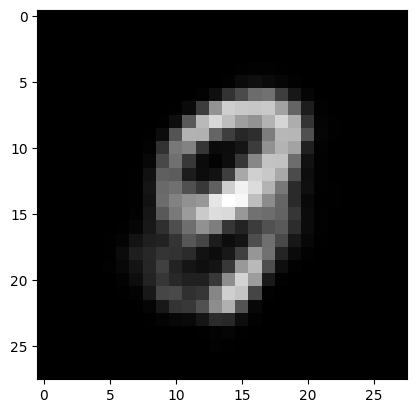

In [113]:
plt.imshow(model.decoder(torch.randn(Z_DIM).to(device)).cpu().view(*IMG_SIZE).detach().numpy(), cmap='gray') 